In [1]:
#Librerías
import numpy as np
import math as mt
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
#import gensim
#####NUEVAS######
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.layers import MaxPooling1D
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from hunspell import Hunspell
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
def processData(path):
    #Sección de Variables
    col_names = ["ID","TEXTO","POLARIDAD"]
    #Lectura del archivo csv Train\n",
    df = pd.read_csv(path, header=None, names = col_names)
    length = len(df)-1
    #Se elimina la primera columna donde esta en el encabezado ID,CONTENT,POLARITY
    df = df.drop([0])
    
    #Se separan las sentencias y la polaridad
    x_df=df['TEXTO']
    y_df=df['POLARIDAD']    
    
    #Se limpian las sentencias(X_DF) y se asignan a X_SENTENCES, Ademas se crea un array de los LABEL(POLARIDAD)
    x_sentences= clean_text(x_df)
    x_sentences=np.array(x_sentences)
    y_label= y_df.to_numpy()
    #Separa la data en entrenamiento y prueba la prueba por ahora son del 25% de los datos
    sentences_train, sentences_test, label_train, label_test = train_test_split(x_sentences,y_label, test_size=0.25, random_state=1000)    
    return sentences_train, sentences_test, label_train, label_test

In [3]:
def clean_text(sentencias, remove_stopwords = False):
    sentences_clean=[]
    for text in sentencias:
        # convierte la sentencia a minuscula
        text = text.lower()
        #Elimina Caracteres que NO se usaran
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
        text = re.sub(r'\¿|“|”|¡|«|»|—|<|^|{|}|>', ' ', text)
        text = re.sub(r'[\n]', '', text)
        
        #remueve stop words
        if remove_stopwords:
            text = text.split()
            stops = set(stopwords.words("English"))
            text = [w for w in text if not w in stops]
            text = " ".join(text)
        sentences_clean.append(text)
    
    sentences_clean=np.array(sentences_clean)
    return sentences_clean

In [4]:
def create_embedding():
    embeddings_index = {}
    with open('numberbatch.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            tagEn="/c/en/"
            tagMul="/c/mul/"
            if tagEn in word or tagMul in word:                
                embedding = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = embedding  
    return embeddings_index     

In [5]:
def sentences_to_vector(sentences_train,sentences_test,embeddings_index):
   #*************PROCESOS PARA EL ENTRENAMIENTO*****************
    #Se llama a la funcion que crear el vector con los embeddings
    trainData=sentences_train #Leer Data
    i=0
    j=0
    h = Hunspell()
    #Vector que almacenara el vector tokenizado y en word embedding
    vectorEmbeddingsTrain=[]
    while(i<len(trainData)):
        #El texto esta plano en el array
        texto=trainData[i]
        #La función split divide el texto por los espacios creando un array
        palabras=texto.split()
        arrayAux=[]
        j=0
        while(j<len(palabras)):
            try:
                arrayAux.append(embeddings_index['/c/en/'+palabras[j].strip()])
            except KeyError:
                try:
                    arrayAux.append(embeddings_index['/c/mul/'+palabras[j].strip()])
                except KeyError:
                    try:
                        palabraux=palabras[j]
                        word=h.suggest(palabraux)
                        if(len(word)>0):
                            arrayAux.append(embeddings_index['/c/en/'+word[0]])
                    except (UnicodeError, KeyError):
                        pass
            j+=1
        i+=1
        arrayAux=np.array(arrayAux)
        vectorEmbeddingsTrain.append(arrayAux)
    trainSentencesEmbedding=[]
    i=0
    while(i<len(vectorEmbeddingsTrain)):
        trainSentencesEmbedding.append(np.average(vectorEmbeddingsTrain[i],axis=0))
        i+=1
     #*************PROCESOS PARA EL TEST*****************
    #Se llama a la funcion que crear el vector con los embeddings
    testData=sentences_test #Leer Data
    i=0
    j=0
    #Vector que almacenara el vector tokenizado y en word embedding
    vectorEmbeddingsTest=[]
    while(i<len(testData)):
        #El texto esta plano en el array
        textoTest=testData[i]
        #La función split divide el texto por los espacios creando un array
        palabrasTest=textoTest.split()
        arrayAuxTest=[]

        j=0
        while(j<len(palabrasTest)):
            try:
                arrayAuxTest.append(embeddings_index['/c/en/'+palabrasTest[j].strip()])
            except KeyError:
                try:
                    arrayAuxTest.append(embeddings_index['/c/mul/'+palabrasTest[j].strip()])
                except KeyError:
                        try:
                            palabraux=palabrasTest[j]
                            word=h.suggest(palabraux)
                            if(len(word)>0):
                                arrayAuxTest.append(embeddings_index['/c/en/'+word[0]])
                        except (UnicodeError, KeyError):
                            pass
            j+=1
        i+=1
        arrayAuxTest=np.array(arrayAuxTest)
        vectorEmbeddingsTest.append(arrayAuxTest)
    testSentencesEmbedding=[]
    i=0
    while(i<len(vectorEmbeddingsTest)):
        testSentencesEmbedding.append(np.average(vectorEmbeddingsTest[i],axis=0))
        i+=1
    trainSentencesEmbedding=np.array(trainSentencesEmbedding)
    testSentencesEmbedding=np.array(testSentencesEmbedding)
    return trainSentencesEmbedding,testSentencesEmbedding

In [6]:
def limpiaVector(vectorX, vectorY):
    i=0
    vectorXAux=[]
    vectorYAux=[]
    while(i<len(vectorX)):
        if(vectorX[i].size==300):
            vectorXAux.append(vectorX[i])
            vectorYAux.append(vectorY[i])
        i+=1
    vectorXAux=np.array(vectorXAux)
    vectorYAux=np.array(vectorYAux)
    return vectorXAux,vectorYAux

In [7]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [9]:
#Se prepara la data
sentences_train, sentences_test, label_train, label_test=processData("Data3polaridadSD.csv")


In [10]:
embeddings_index=create_embedding()

In [11]:
sentences_Embeddins_Train,sentences_Embeddins_Test=sentences_to_vector(sentences_train,sentences_test,embeddings_index)
sentences_Embeddins_Train,label_train=limpiaVector(sentences_Embeddins_Train,label_train)
sentences_Embeddins_Test,label_test=limpiaVector(sentences_Embeddins_Test,label_test)

C:\Users\nicoc\Anaconda3\envs\tesis3\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\nicoc\Anaconda3\envs\tesis3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:

label_train=to_categorical(label_train,3)
label_test=to_categorical(label_test,3)

In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [14]:
model = Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=(300,)))
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 10,787
Trainable params: 10,787
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(sentences_Embeddins_Train, label_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(sentences_Embeddins_Test, label_test),
                    batch_size=128)

Training results
Training Accuracy: 0.8293
Training Loss: 0.3765
Training f1_score: 0.7234
Training Precisition: 0.7840
Training Recall: 0.6734


Test results
Test Accuracy: 0.8100
Test Loss: 0.4103
Test f1_score: 0.6927
Test Precisition: 0.7501
Test Recall: 0.6452


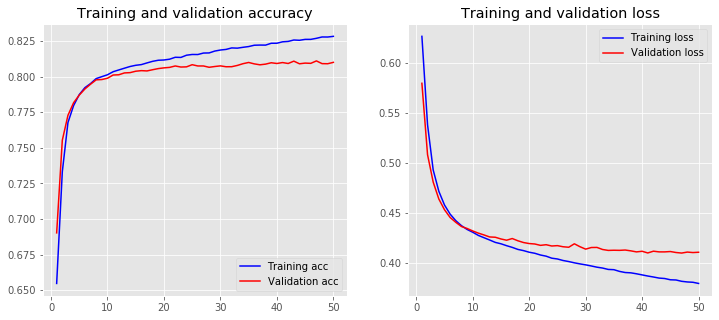

In [16]:
loss, accuracy, f1_score, precision, recall = model.evaluate(sentences_Embeddins_Train, label_train, verbose=0)
print("Training results")
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
print("Training f1_score: {:.4f}".format(f1_score))
print("Training Precisition: {:.4f}".format(precision))
print("Training Recall: {:.4f}".format(recall))
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(sentences_Embeddins_Test, label_test, verbose=0)
print("Test results")
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Loss: {:.4f}".format(loss))
print("Test f1_score: {:.4f}".format(f1_score))
print("Test Precisition: {:.4f}".format(precision))
print("Test Recall: {:.4f}".format(recall))
plot_history(history)

[[2771  559  299]
 [ 608 2114  651]
 [ 226  511 2016]]


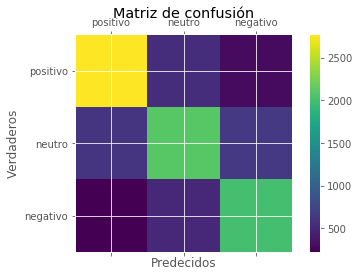

In [17]:
predicciones=model.predict(sentences_Embeddins_Test)
prediction = pd.DataFrame(predicciones, columns=['predicciones','','']).to_csv('prediction.csv')
cm = confusion_matrix(label_test.argmax(axis=1), predicciones.argmax(axis=1))
labels = ['positivo', 'neutro', 'negativo']
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Matriz de confusión')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predecidos')
plt.ylabel('Verdaderos')
plt.show()